In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
nu = notebookUtils()
model_name = "strawmaker"

In [19]:
dataset, features, indicators = nu.loadData(indicators=[('moh', 'time', ''), ('tod', 'time', ''), ('dow', 'time', ''), ('bop', 'close', ''),('optimal_v2', 'close', '')],
                            param_spec={},
                            optimal_threshold={'buy':(0.005, 0.03)},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10,30,60]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2,3,5,10,30]},
                                    {'indicator_name':'natr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [30,60,120,180]},
                                    {'indicator_name':'cmo',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2,3,5,10,60]}
                                    ],
                            scale='minmaxwindow')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi

Loading data from BAT...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from WAVES...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from ZRX...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from XRP...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from ZEC...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from QTUM...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from ETH...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from chunk 5...
Loading data from MATIC...
Loading data from chunk 0...
Loading data from DASH...
Loading data fr

In [20]:
dataset.drop(["time", "open", "high", "low", "volume"], axis=1, inplace=True)
dataset.dropna(inplace=True)
dataset

,close,MOH,TOD,DOW,BOP,optimal,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_10,CCI_close_period_30,...,RSI_close_period_30,NATR_close_period_30,NATR_close_period_60,NATR_close_period_120,NATR_close_period_180,CMO_close_period_2,CMO_close_period_3,CMO_close_period_5,CMO_close_period_10,CMO_close_period_60
15179,0.198272,0,0,0,0.500000,0.0,0.107419,0.214748,0.409122,0.468760,...,0.464963,0.101067,0.130823,0.175470,0.179376,0.248317,0.163216,0.207553,0.333779,0.528606
15180,0.198286,0,0,0,0.500000,0.0,0.127231,0.232374,0.425927,0.469380,...,0.468464,0.097933,0.128389,0.173542,0.177906,0.395288,0.234540,0.238476,0.345332,0.530551
15181,0.198293,0,0,0,0.500000,0.0,0.137136,0.241187,0.438454,0.469690,...,0.470259,0.094595,0.125777,0.171474,0.176329,0.494186,0.280534,0.256606,0.351579,0.531536
15182,0.198646,0,0,0,1.000000,0.0,0.555424,0.607194,0.604705,0.515951,...,0.550515,0.106492,0.133931,0.177132,0.180377,0.970932,0.869646,0.701719,0.576687,0.578370
15183,0.198823,0,0,0,0.500000,0.0,0.772730,0.803597,0.708613,0.545258,...,0.584059,0.110259,0.136467,0.178802,0.181531,0.985036,0.919241,0.782946,0.645155,0.599884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11372817,0.007594,1,0,0,0.500000,0.0,0.460800,0.459889,0.559780,0.481906,...,0.456786,0.402009,0.398147,0.406291,0.446546,0.852420,0.691508,0.580441,0.515838,0.443201
11372818,0.007597,0,0,0,0.645833,0.0,0.730146,0.730341,0.306305,0.363976,...,0.462615,0.520978,0.470578,0.451731,0.482076,0.885579,0.723187,0.600716,0.527163,0.447341
11372819,0.007554,0,0,0,0.954545,0.0,0.569340,0.568874,0.220174,0.285220,...,0.389904,0.616028,0.531111,0.491651,0.514611,0.111013,0.213221,0.309746,0.372351,0.396703
11372820,0.007537,0,0,0,0.576923,0.0,0.547746,0.506659,0.462815,0.414331,...,0.365766,0.668616,0.566260,0.515193,0.533718,0.066315,0.151482,0.251090,0.329957,0.378854


In [21]:
dataset['optimal'].unique()

array([0., 1.])

In [52]:
trainX, testX, trainy, testy = nu.splitData(dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':32, 'superset_class_val':0, 'randomize_concat':True})
trainX

,close,MOH,TOD,DOW,BOP,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_10,CCI_close_period_30,CCI_close_period_60,...,RSI_close_period_30,NATR_close_period_30,NATR_close_period_60,NATR_close_period_120,NATR_close_period_180,CMO_close_period_2,CMO_close_period_3,CMO_close_period_5,CMO_close_period_10,CMO_close_period_60
0,0.165965,0,0,0,0.500000,0.657705,0.882533,0.649996,0.655316,0.607969,...,0.645930,0.192193,0.212215,0.254900,0.275054,0.963161,0.892061,0.824626,0.741356,0.602476
1,120.046245,0,0,1,0.500000,0.555005,0.557579,0.344731,0.464288,0.324559,...,0.573803,0.095136,0.114315,0.150187,0.198091,0.000352,0.005469,0.050267,0.240046,0.650915
2,4.461959,0,0,0,0.000000,0.612414,0.498930,0.504341,0.490042,0.541833,...,0.536980,0.154939,0.191867,0.192653,0.228889,0.167560,0.323100,0.422808,0.479255,0.575474
3,2.397796,0,0,1,0.500000,0.550332,0.599779,0.757266,0.488463,0.580847,...,0.556240,0.160503,0.298627,0.484976,0.629919,0.935953,0.874572,0.763700,0.652762,0.472708
4,2.690944,0,0,0,0.281250,0.046199,0.366923,0.367525,0.543258,0.655028,...,0.494663,0.192760,0.258409,0.275363,0.247742,0.029834,0.104277,0.234384,0.406706,0.464743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3564886,4.465489,0,0,0,0.814815,0.555196,0.357017,0.582334,0.512395,0.442626,...,0.420310,0.414714,0.549245,0.652457,0.750961,0.687379,0.563533,0.517840,0.473671,0.455320
3564887,0.010360,0,0,0,0.500000,0.752745,0.503382,0.489456,0.494063,0.454005,...,0.462793,0.170843,0.202007,0.224607,0.243150,0.251408,0.465142,0.531806,0.512838,0.451751
3564888,0.013351,0,0,0,0.500000,0.136456,0.333383,0.264195,0.373240,0.426531,...,0.450253,0.194733,0.243633,0.257013,0.240309,0.006189,0.040962,0.143881,0.326942,0.450641
3564889,1.840286,0,0,0,0.500000,0.824799,0.830426,0.593740,0.619179,0.567064,...,0.538952,0.039674,0.047734,0.046394,0.035712,0.663677,0.728370,0.709693,0.674065,0.436512


In [53]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.515625, 1: 16.5}

In [71]:
clf = XGBClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='entropy', min_samples_leaf=4)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf.score(testX.drop("close", axis=1).values, testy.values))

# feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

# for i in range(len(feature_importances.importances_mean)):
#     print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

[13:27:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { class_weight, criterion, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9880711863811247


In [109]:
reduced_classified_data = nu.classifyPoints([clf], testX, predict_proba=True, proba_thresh=[0.15], plot_optimal=True, optimal=testy)

In [112]:
smaller_view_data = reduced_classified_data[6000:7000]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

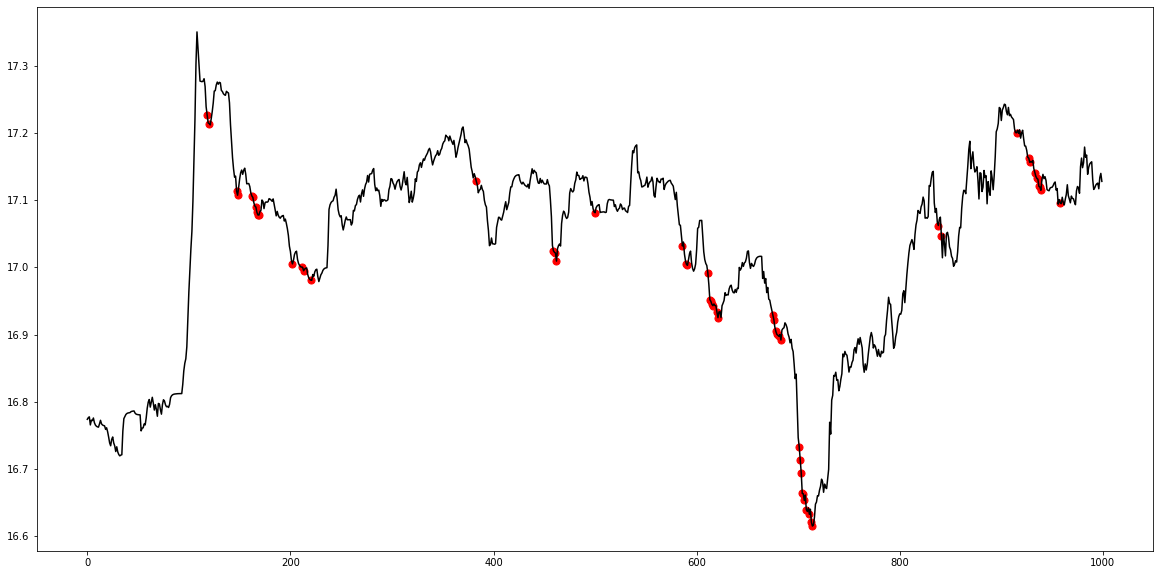

In [113]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=False)

In [42]:
model_version = nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.5, is_nn=False)

In [16]:
# score, trades = nu.testModel(model_name)

In [17]:
# updateScoreboard(model_name, model_version, score, trades, features)

In [ ]:
#1.5 is the best one. XGBoost with no time features
#1.6 is next one with RF and time features